# Import

In [77]:
import MDAnalysis as mda
#from MDAnalysis.analysis import contacts
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
import MDAnalysis.analysis.hbonds as hb
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import seaborn as sns
from itertools import product
import inspect
import pandas as pd
import multiprocessing 
import time
import os 
import glob

# Function definitions

## SB

In [78]:
def SaltBridge(u, nres, sel_acidic, sel_basic, nframe, sb_file="sb.dat", cutoff=4.5):
    # For the membrane we added the carboxylic group of DGPS in analogy to GLU/ASP

    # Selection taken from the pyinteraph paper, different from charged_groups.ini
    # Added calcium ions as charged residue for salt bridges 
    # sel_basic = "(resname LYS and name NZ HZ*) or (resname ARG and name CZ NH* 1HH* 2HH*) or resname CAL"
    # sel_acidic = "(resname ASP and name CG OD*) or (resname GLU and name CD OE*) or (resname DGPS and name C13 O13A O13B)"

    # Histidine must be accounted for when its protonation state gives it a charge, i.e. when both Nϵ
    # and Nδ have hydrogens.
    
    # reference groups (first frame of the trajectory, but you could also use a
    # separate PDB, eg crystal structure)
    acidic = u.select_atoms(sel_acidic)
    basic = u.select_atoms(sel_basic)


    salt_bridge = np.zeros((nres, nres), int)

    for ts in u.trajectory:
        AA = capped_distance(acidic.positions, basic.positions, max_cutoff=cutoff, return_distances=False, box=acidic.dimensions)
        # At least for salt bridges, we need only that one bridge is formed. 
        # Therefore we will map the pairs of atoms indices into the pairs of 
        # residues and take the unique pair to compose the matrix.
        # It is symmetric, but we can use the upper diagonal part.
        residxs = []
        for resAcid,resBasic in zip(acidic[AA[:,0]].resindices, basic[AA[:,1]].resindices):
             residxs.append([resAcid,resBasic])
        residxs = np.unique(np.array(residxs), axis=0) # shifting back
        for r in residxs:
            salt_bridge[r[0],r[1]] += 1

    pref = 1.
    SSBB = (salt_bridge+salt_bridge.T)*pref / nframe
    np.savetxt(sb_file,SSBB)
#     return SSBB

## Hydrophobic interaction

In [80]:
def HydrophobicInteraction(u, nres, sel, nframe, hc_file="hc.dat", cutoff=5.51):
    hcMatrix = np.zeros((nres, nres), int)
    for ts in u.trajectory:
        hydroDists, _ = self_capped_distance(sel.center_of_mass(compound='residues', pbc=True),
                                             max_cutoff=cutoff,
                                             box=sel.dimensions)

        for pair in hydroDists:
            res1 = sel.residues[pair[0]].resindex
            res2 = sel.residues[pair[1]].resindex
            hcMatrix[res1, res2] += 1
            if res1 != res2:
                hcMatrix[res2, res1] += 1

    pref = 1.
    normed_hcMatrix = (hcMatrix)*pref /nframe
    np.savetxt(hc_file, normed_hcMatrix)
#     return normed_hcMatrix

## H bonds

In [81]:
def parallel_hb(PDB, XTC, start, stop, sel1, sel2, up_sel1=False, up_sel2=False, dist=3.5, angle=120.0,
                accepts=[], dons=[], csv_name="hb"):
    print('inizializzo: ' + multiprocessing.current_process().name)
    input_uni = mda.Universe(PDB, XTC)
    input_hb = hb.HydrogenBondAnalysis(input_uni, sel1, sel2, 
                                       update_selection1=up_sel1, 
                                       update_selection2=up_sel2,
                                       distance=dist, angle=angle,
                                       acceptors=accepts,
                                       donors=dons,
                                       pbc=True)
#     print(f"distance: {input_hb.distance}")
    input_hb.run(start=start, stop=stop)
    hb_csv = f'{csv_name}_{start}_{stop}.csv'
    input_hb.generate_table()
    df = pd.DataFrame.from_records(input_hb.table)
    df.to_csv(hb_csv)

    

In [82]:
def defineIntervals(nframe, ncores=0):
    """ using ncores=0, means you are using all the cores available"""
    if not ncores:
        print("using all the available cores")
        ncores = multiprocessing.cpu_count()
    traj_per_core = nframe//ncores
    intervals=[]
    for i in range(ncores):
        if i == ncores-1:
            # the None value allows the computation up to the last frame
            intervals.append((i*traj_per_core, None))
        else:
            intervals.append((i*traj_per_core, (i+1)*traj_per_core))
    return intervals

In [83]:
def HBondInteraction(PDB, XTC, sel1, sel2, nframe, output_name, ncores=0): 
    "write files "
    intervals = defineIntervals(nframe, ncores)
    pool = multiprocessing.Pool()
    for start, stop in intervals:
        pool.apply_async(parallel_hb, args=(PDB, XTC, start, stop, sel1, sel2), 
                                      kwds={'dist': 3.5, 
                                            'angle': 120.0,
                                            'accepts': lipidic_acceptors,
                                            'dons': lipidic_donors, 
                                            'csv_name': f"hb_{output_name}"})
    pool.close()
    pool.join()


In [84]:
def MergingHBDataframe(output_name, nframe, ncores=0):
    # merging data frames
    intervals = defineIntervals(nframe, ncores)
    df_list = []
    for start, stop in intervals:
        df_list.append(pd.read_csv(f'hb_{output_name}_{start}_{stop}.csv', usecols=['time', 'donor_index', 'acceptor_index']))

    hb_df = pd.concat(df_list, ignore_index=True)
    return hb_df

In [85]:
def HBMatrix(u, nres, nframe, hb_df, hb_file="hb.dat"):
    # creating the dictionary to convert atom index into resindex
    index2resindex = {}
    for atom in u.atoms:
        index2resindex[atom.index] = atom.resindex
    #creating column with donor and acceptor resindices
    hb_df['d_resindex'] = hb_df['donor_index'].map(index2resindex)
    hb_df['a_resindex'] = hb_df['acceptor_index'].map(index2resindex)
    # removing unnecessary columns
    hb_df.drop(['donor_index', 'acceptor_index'], axis=1, inplace=True)
    # creating a string to assess the equivalence of the pairs like 11-12 and 12-11
    hb_df['check_pair'] = hb_df.apply(lambda row: '-'.join(sorted([f"{row['d_resindex']:.0f}", f"{row['a_resindex']:.0f}"])), axis=1)
    #removing the same hb at the same time step
    hb_df.drop_duplicates(subset=['time', 'check_pair'], inplace=True)
    #cleaning the dataframe
    hb_df.drop('check_pair', axis=1, inplace=True)

    #creating the matrix
    hbMatrix = np.zeros((nres,nres))

    for index, row in hb_df.iterrows():
        time, d_residx, a_residx = row
        i = int(d_residx)
        j = int(a_residx)
        hbMatrix[i,j] += 1
        if (i!=j):
            hbMatrix[j,i] += 1
    pref = 1.
    fullHB = hbMatrix*pref / nframe
    # Saving matrices:
    np.savetxt(hb_file, fullHB)
                                                                   
#     return fullHB

# Initialisations

In [86]:
# # Initialising the files 
# PDB = 'pyfferaph/new_temp/temp/rec_r_prot_r2_extended.pdb'
# XTC = 'pyfferaph/new_temp/temp/rec_r_prot_r2.xtc'

# only_protein = True

# if only_protein:
#     # to build the matrix, define all atoms you want to consider
#     atoms_for_matrix = 'resname GLM or protein or resname CAL'
#     # salt bridge
#     sel_basic = "(resname LYS and name NZ HZ*) or (resname ARG and name CZ NH* 1HH* 2HH*) or resname CAL"
#     sel_acidic = "(resname ASP and name CG OD*) or (resname GLU and name CD OE*)"
#     # hydrophobic
#     backbone = "name N HN CA HA C O OT1 OT2 HT2"
#     hydrophobicResidues = "resname ALA ILE VAL LEU PHE MET TRP PRO GLM"
    
#     # for h-bonds
#     sel1 = 'protein or resname GLM'
#     sel2 = 'protein or resname GLM'
#     lipidic_donors = []
#     lipidic_acceptors = []
# else:
#     # to build the matrix, define all atoms you want to consider
#     atoms_for_matrix = 'resname GLM or protein or resname CAL or resname DGPS DGPC DGPE'
#     # salt bridge
#     sel_basic = "(resname LYS and name NZ HZ*) or (resname ARG and name CZ NH* 1HH* 2HH*) or resname CAL"
#     sel_acidic = "(resname ASP and name CG OD*) or (resname GLU and name CD OE*) or (resname DGPS and name C13 O13A O13B)"
#     # hydrophobic
#     backbone = "name N HN CA HA C O OT1 OT2 HT2"
#     hydrophobicResidues = "resname ALA ILE VAL LEU PHE MET TRP PRO GLM"
#     chain1 = "O21 O22 C21 C22 C23 C24 C25 C26 C27 C28 C29 0C21 1C21 2C21 3C21 4C21 5C21 6C21 7C21 8C21 9C21 0C22"
#     chain2 = "O31 O32 C31 C32 C33 C34 C35 C36 C37 C38 C39 0C31 1C31 2C31 3C31 4C31 5C31 6C31 7C31 8C31 9C31 0C32"
    
#     # for h-bonds
#     sel1 = 'protein or resname GLM'
#     sel2 = 'resname GLM or protein or resname CAL or resname DGPS DGPC DGPE'
#     lipidic_donors =[]
#     lipidic_acceptors = ["O12", "O13", "O14", "O11", "O21", "O22", "O31", "O32", "O13A", "O13B"]

In [87]:
# to build the matrix, define all atoms you want to consider
atoms_for_matrix = 'resname GLM or protein or resname CAL or resname DGPS DGPC DGPE'
# salt bridge
sel_basic = "(resname LYS and name NZ HZ*) or (resname ARG and name CZ NH* 1HH* 2HH*) or resname CAL"
sel_acidic = "(resname ASP and name CG OD*) or (resname GLU and name CD OE*) or (resname DGPS and name C13 O13A O13B)"
# hydrophobic
backbone = "name N HN CA HA C O OT1 OT2 HT2"
hydrophobicResidues = "resname ALA ILE VAL LEU PHE MET TRP PRO GLM"
chain1 = "O21 O22 C21 C22 C23 C24 C25 C26 C27 C28 C29 0C21 1C21 2C21 3C21 4C21 5C21 6C21 7C21 8C21 9C21 0C22"
chain2 = "O31 O32 C31 C32 C33 C34 C35 C36 C37 C38 C39 0C31 1C31 2C31 3C31 4C31 5C31 6C31 7C31 8C31 9C31 0C32"

# for h-bonds
sel1 = 'protein or resname GLM'
sel2 = 'resname GLM or protein or resname CAL or resname DGPS DGPC DGPE'
lipidic_donors =[]
lipidic_acceptors = ["O12", "O13", "O14", "O11", "O21", "O22", "O31", "O32", "O13A", "O13B"]




In [88]:
# Initialising the files 
PDB = 'sim.prot.A.pdb'
XTC = 'traj.xtc'
output_name = "example"

In [89]:
sb_file = f"sb_{output_name}.dat"
hb_file = f"hb_{output_name}.dat"
hc_file = f"hc_{output_name}.dat"
# hb_csv = "hb_dataframe.csv"

In [90]:
u = mda.Universe(PDB, XTC)
NFRAME = u.trajectory.n_frames

In [91]:
sel = u.select_atoms(atoms_for_matrix)
residxs = np.unique(sel.resindices)
nres = len(residxs)

# Analysis

In [92]:
SaltBridge(u, nres, sel_acidic, sel_basic, NFRAME, sb_file=sb_file, cutoff=4.5)

In [93]:
# if only_protein:
#     hcSel = u.select_atoms(f"{hydrophobicResidues} and (not {backbone})")
# else:
#     hcSel = u.select_atoms(f"{hydrophobicResidues} and (not {backbone}) or (resname DGP* and name {chain1} {chain2})")

# HydrophobicInteraction(u, nres, sel=hcSel, hc_file="hc.dat", cutoff=5.51)

In [94]:
hcSel = u.select_atoms(f"{hydrophobicResidues} and (not {backbone}) or (resname DGP* and name {chain1} {chain2})")

HydrophobicInteraction(u, nres, hcSel, NFRAME, hc_file=hc_file, cutoff=5.51)

In [95]:
# creates the small csv file
HBondInteraction(PDB, XTC, sel1, sel2, NFRAME, output_name, ncores=0)

# Merging the dataframe
hb_df = MergingHBDataframe(output_name, NFRAME, ncores=0)

# cleaning df and creating the matrix
HBMatrix(u, nres, NFRAME, hb_df, hb_file=hb_file)

using all the available cores
inizializzo: ForkPoolWorker-8
inizializzo: ForkPoolWorker-5
inizializzo: ForkPoolWorker-7
inizializzo: ForkPoolWorker-6
using all the available cores


# FILTERGRAPH

In [158]:
from collections import namedtuple

In [159]:
import seaborn as sns

In [160]:
hcMatrix=np.loadtxt(hc_file)
normed_hcMatrix = hcMatrix / hcMatrix.max()
full_HB = np.loadtxt(hb_file)
ssbb = np.loadtxt(sb_file)

AllMatrices = namedtuple('AllMatrices',['hc','ssbb','hb_full'])

In [161]:
all_mats = AllMatrices(hc=normed_hcMatrix, ssbb=ssbb, hb_full=full_HB)

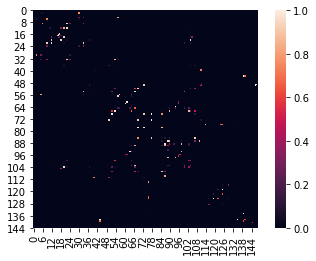

In [162]:
sns.heatmap(hcMatrix,square=True)

In [163]:
import networkx as nx

from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.special import expit

In [164]:
# Parametric sigmoid function for fitting
def sigmoid(x, x0, k, m, n): 
    y = m / (1 + np.exp(k*(x-x0))) + n
    return y

# Parametric analytic second derivative of sigmoid 
def seconddevsigmoid(x, x0, k, l, m): 
    y = ( k**2 * l * np.exp(k*(x+x0)) * ( np.exp(k*x)-np.exp(k*x0) )  )   /   ( np.exp(k*x0) + np.exp(k*x) )**3    
    return y    


In [176]:
vals = np.arange(0, 1, 0.02)

In [177]:
matrices = [hcMatrix]

In [178]:
maxclustsize = []

for val in vals:       
    boolmats = [i>val for i in matrices]
    if len(boolmats) > 1:
         allmat = np.logical_or(*boolmats)
    else:
         allmat = boolmats[0]
    G=nx.Graph(allmat)
#     print(len(max(nx.connected_components(G), key=len)))
    maxclustsize.append(len(max(nx.connected_components(G), key=len)))
#     print(maxclustsize)

x = vals
y = maxclustsize


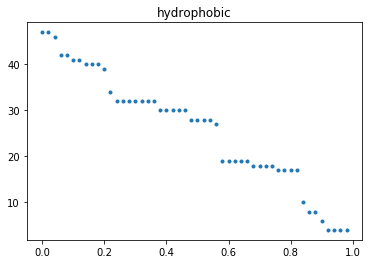

In [179]:
plt.plot(x,y, '.')
plt.title("hydrophobic");

In [180]:
popt, pcov = curve_fit(sigmoid, x, y, p0=(0.4,50,50,1), maxfev=1000000)#(options.x0, options.k, options.m, options.n) )
print(f"Value computed from the fitting: {popt}")
print(f"Covariance of the fitting with initial guess {np.sqrt(np.diag(pcov))}")
# popt, pcov = curve_fit(sigmoid, x, y, maxfev=100000)#(options.x0, options.k, options.m, options.n) )
# print(f"Value computed from the fitting: {popt}")
# print(f"Covariance of the fitting without initial guess {np.sqrt(np.diag(pcov))}")

Value computed from the fitting: [ 1.33378821e+01  4.93366737e-01  4.76089584e+04 -4.74982531e+04]
Covariance of the fitting with initial guess [nan nan nan nan]


/home/tubiana/usr/src/anaconda3/envs/QCB/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [181]:
args=tuple(popt)
flex = fsolve(seconddevsigmoid, 10, args=args, maxfev=5000) 
print(f'hydrophobic flex {flex}')

hydrophobic flex [-1506.96320428]


/home/tubiana/usr/src/anaconda3/envs/QCB/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Flexus at: [-1506.96320428]


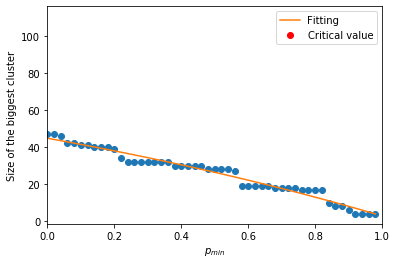

In [182]:
plt.plot(x, y, 'o')
plt.xlim((0, 1))
plt.xlabel("$p_{min}$")
plt.ylabel("Size of the biggest cluster")
if args:
    xplot = np.linspace(max(x),min(x))
    yplot = sigmoid(xplot, *popt)
    plt.plot(xplot, yplot, label='Fitting')

if flex:
    plt.plot(flex,sigmoid(flex,*popt),'o',label = 'Critical value', color = 'red')
    plt.axvline(x=flex)

plt.legend(loc='best');
print(f"Flexus at: {flex}")

#### For all matrices

In [ ]:
hb = pd.read_csv(hb_file, sep=" ", header=None).values
sb = pd.read_csv(sb_file, sep=" ", header=None).values
hc = pd.read_csv(hc_file, sep=" ", header=None).values

In [ ]:
matrices_piffo = [hb, sb, hc]

boolmats = [i > 20.4 for i in matrices_piffo]
out_matrix_piffo = boolmats[0]

for i in range (1,len(boolmats)):
    out_matrix_piffo = np.logical_or(out_matrix_piffo, boolmats[i])

In [ ]:
out_IIN = 'state_piffo_unweighted_all.dat'
np.savetxt(out_IIN, out_matrix_piffo, fmt='%d')
out_matrix_piffo = np.loadtxt(out_IIN, dtype=int)

In [ ]:
piffo_state = pd.read_csv(out_IIN, sep=" ", header=None, dtype=int).values

In [ ]:
piffo_state_bool = piffo_state > 20.4 

In [ ]:
sns.heatmap(piffo_state_bool, square=True)